# Module importing

Imports: All imports are added in the below cell.

In [1]:
##imports
import time
print(time.asctime())

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn import preprocessing
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Wed Nov 21 15:37:26 2018


# Constants

Constants: All constants are added in the below cell.

In [2]:
%%time

print(time.asctime())

##constants
null_val_threshold = 90
unique_threshold   = 1
output_variable = 'isAnomaly' 
variance_threshold = 0.9*(1-0.9)

Wed Nov 21 15:37:47 2018
CPU times: user 154 µs, sys: 32 µs, total: 186 µs
Wall time: 159 µs


# Reading input data

Read the train_data.csv file to a pandas dataframe "original_train_df". Save the dataframe to pickle "originaltrainpickle". 
1) The shape of training dataframe is (750199, 237), i.e., 750199 samples and 237 features.
2) The size of dataframe is 1.320GB.

In [3]:
%%time

print(time.asctime())

# Read data
original_train_df = pd.read_csv("/home/fedora/programs/group3/Challenge_A/operational_data/train_data.csv",
                                sep=",",
                                #lineterminator="\n",
                                header=0)
print("\noriginal train data shape", original_train_df.shape)
print ("\nmemory footprint of original train df = %0.3fGB" %(original_train_df.memory_usage(deep=True).sum()/1024**3))
original_train_df.to_pickle("originaltrainpickle")


Wed Nov 21 15:37:47 2018

original train data shape (750199, 237)

memory footprint of original train df = 1.320GB
CPU times: user 28.3 s, sys: 5.33 s, total: 33.7 s
Wall time: 46.1 s


Show the data description
What can be inferred from the below description?
1) There seem to be many features with single unique values (mainly 0 values)
2) The min and max values of different features shows high variance. It seems the different feature values are having different spread(std shows high spread).

In [4]:
%%time

print(time.asctime())

## Lst us print the description of training data
print(original_train_df.describe())

Wed Nov 21 15:38:33 2018
          Unnamed: 0   Unnamed: 0.1           host        process  \
count  750199.000000  750199.000000  750199.000000  750199.000000   
mean   375099.000000   19066.559100       4.329551       0.500103   
std    216563.941634   11379.675984       2.847125       0.500000   
min         0.000000       0.000000       0.000000       0.000000   
25%    187549.500000    9370.000000       2.000000       0.000000   
50%    375099.000000   18750.000000       4.000000       1.000000   
75%    562648.500000   28140.000000       7.000000       1.000000   
max    750198.000000   54030.000000       9.000000       1.000000   

       Prepared statement cache hit rate : ((MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheHitCount / MXBean(com.bea:Name=source06,Type=JDBCDataSourceRuntime).PrepStmtCacheMissCount))  \
count                                      750199.000000                                                                                      

# Extracting target feature

The target feature ("isAnomaly") need to be seperated from train data. So this is extracted to a seperate dataframe 
"anomalies_df". After separation,the train data is saved to pickle "trainpickle" and anomaly data(train target) is 
saved to pickle "anomaliespickle".

In [5]:
%%time

print(time.asctime())

input_variables = [variable for variable in list(original_train_df.columns.values) if variable != output_variable]
anomalies_df = original_train_df[output_variable]
train_df = original_train_df[input_variables]
print("\ntraining data shape excluding anomalies", train_df.shape)
print("\nanomalies data shape", anomalies_df.shape)
print("counts of label 'True' in anomalies: {}".format(sum(anomalies_df == True)))
print("counts of label 'False' in anomalies: {}".format(sum(anomalies_df == False)))

train_df.to_pickle("trainpickle")
anomalies_df.to_pickle("anomaliespickle")

del original_train_df

Wed Nov 21 15:38:40 2018

training data shape excluding anomalies (750199, 236)

anomalies data shape (750199,)
counts of label 'True' in anomalies: 14363
counts of label 'False' in anomalies: 735836
CPU times: user 785 ms, sys: 2.91 s, total: 3.69 s
Wall time: 7.39 s


The "isAnomaly" feature is having boolean "True" and "False". Let us replace it with 1 and 0 respectively.

In [6]:
%%time

print(time.asctime())

## Replacing True with 1 and false with 0 in anomalies data frame
anomalies_df = anomalies_df.replace(True, 1)
anomalies_df = anomalies_df.replace(False, 0)
print("counts of label 'True' in anomalies: {}".format(sum(anomalies_df == 1)))
print("counts of label 'False' in anomalies: {}".format(sum(anomalies_df == 0)))

anomalies_df.to_pickle("anomaliespickle")

Wed Nov 21 15:38:48 2018
counts of label 'True' in anomalies: 14363
counts of label 'False' in anomalies: 735836
CPU times: user 2.19 s, sys: 111 ms, total: 2.3 s
Wall time: 297 ms


# Filtering out non significant features

Feature filtering: Following feature filtering rules are applied.
1) All null features are removed(this rule will anyways be fulfilled in the next rule(2)).
2) All features with null values greater than null_val_threshold(90%)are removed.
3) All features with single unique values are removed.
After applying the above rules, 67 features are selected for dropping. So they are dropped and remaining number of features have become 169.    

In [7]:
%%time

print(time.asctime())

## columns to drop if all feature values are null
## columns to drop if there are more than 90% null values in the feature
## columns to drop if all values are unique in the feature
cols_to_drop = [col for col in train_df.columns 
                if ((train_df[col].isnull().all())                                                 
                    or (((train_df[col].isnull().sum(axis = 0)/len(train_df[col])) * 100) >  null_val_threshold)
                    or (len(train_df[col].unique()) == unique_threshold))]
print("\nlength of columns to drop", len(cols_to_drop))

## Dropping the identified features till now
train_df.drop(columns=cols_to_drop, inplace=True)
print("\nshape of train df after dropping few columns", train_df.shape)
print ("\nmemory footprint of train df = %0.3fGB" %(train_df.memory_usage(deep=True).sum()/1024**3))

train_df.to_pickle("trainpickle")


Wed Nov 21 15:38:48 2018

length of columns to drop 67

shape of train df after dropping few columns (750199, 169)

memory footprint of train df = 0.945GB
CPU times: user 34.2 s, sys: 3.35 s, total: 37.5 s
Wall time: 9.94 s


Are there null values still. If so, either those samples are to removed or data has to be imputed with some values (either 0 or most frequent values of the feature). But, no null values are observed. So no data imputation techniques need to be followed.

In [8]:
%%time

print(time.asctime())

## Is there any NULL values in training data?
## If there are NULL values, then some imputation methods are to be employed.
print(train_df.isnull().values.any())

## Fill missing values with 0
train_df.fillna(0, inplace=True)
##print("\nshape of train df after dropping few columns", train_df.shape)
##print ("\nmemory footprint of train df = %0.3fGB" %(train_df.memory_usage(deep=True).sum()/1024**3))

Wed Nov 21 15:38:58 2018
False
CPU times: user 1.91 s, sys: 81.3 ms, total: 1.99 s
Wall time: 382 ms


The training data description indicated a need for variance filtering on training data. Used VarianceThreshold API from sklearn.feature_selection for such a filtering. This reduced the number of features to 63 features. So training will be done with these 63 features. Note that the we have identified that only 63 out of original 236 features may have impact on target predictions.

In [9]:
%%time

print(time.asctime())

## identifying and dropping features with vairance below variance_threshold
Var = VarianceThreshold(threshold=variance_threshold).fit(train_df)
indx  = Var.get_support(indices=True) 
train_df = train_df.iloc[:,indx]
print("\nshape of train df after applying variance", train_df.shape)
print ("\nMemory footprint of train df = %0.3fGB" %(train_df.memory_usage(deep=True).sum()/1024**3))

train_df.to_pickle("trainpickle")

Wed Nov 21 15:38:58 2018

shape of train df after applying variance (750199, 63)

Memory footprint of train df = 0.352GB
CPU times: user 7.45 s, sys: 2.13 s, total: 9.58 s
Wall time: 2.22 s


# Scaling of feature values

Feature scaling: The data description shows the need for feature scaling. Originally we didn't use any feature scaling technique. We have done the training of those 63 feature samples using KNN(K-Nearest Neighbor) classifier after splitting the data into fitting and validation set. Below is the the result that we have obtained.

F1 (weighted) = 0.9796880998298155

Precision (None) = [0.98587054 0.640599  ]

Recall (None) = [0.99706456 0.26801253]

F1 (None) = [0.99143596 0.37791411]

confusion_matrix = [[146735    432]
                    [  2103    770]]
                    
                    
But then the feature scaling started to give better predictions. We used MinMaxScaler from sklearn.preprocessing for feature scaling. The value are scaled in the range o to 1. The results can be viewed from later cells.

In [10]:
%%time

print(time.asctime())

## applying scaling on train data set, range (0,1)
scaler = preprocessing.MinMaxScaler()
scaled_train_df = scaler.fit_transform(train_df)
scaled_train_df = pd.DataFrame(scaled_train_df, columns=train_df.columns)
print("\nshape of full chunk df after minmax scaling", scaled_train_df.shape)
print ("\nMemory footprint of minmax scaled chunk df = %0.3fGB" %(scaled_train_df.memory_usage(deep=True).sum()/1024**3))   
## Write the resultant dataframe to a pickle
scaled_train_df.to_pickle("scaledtrainpickle")

print("\nscaled train data description", scaled_train_df.describe())

del train_df

Wed Nov 21 15:39:01 2018


/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



shape of full chunk df after minmax scaling (750199, 63)

Memory footprint of minmax scaled chunk df = 0.352GB

scaled train data description           Unnamed: 0   Unnamed: 0.1           host        process  \
count  750199.000000  750199.000000  750199.000000  750199.000000   
mean        0.500000       0.352888       0.481061       0.500103   
std         0.288676       0.210618       0.316347       0.500000   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.250000       0.173422       0.222222       0.000000   
50%         0.500000       0.347029       0.444444       1.000000   
75%         0.750000       0.520822       0.777778       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

       Heap usage activity : (d/dx (MXBean(java.lang:type=Memory).HeapMemoryUsage.used))  \
count                                      750199.000000                                   
mean                                            0.6

See below the description of scaled data.

# Train test split

Now, its time to split the train data to fitting and validation data. We used train_test_split from sklearn.model_selection for this purpose. The test_size is set as 20%. Here is the fitting and validation data shapes after splitting.

training input shape is (600159, 63)

validation input shape is (150040, 63)

In [11]:
%%time

print(time.asctime())

train_df  = pd.read_pickle("scaledtrainpickle")
## Splitting into training and validation set
sets = train_test_split(train_df, anomalies_df, test_size=0.20, stratify=anomalies_df)
X_train = sets[0]
y_train = sets[2]
X_test  = sets[1]
y_test  = sets[3]

## shape of training and validation set
print("training input is \n", X_train.shape)
print("training output is \n",y_train.shape)
print("validation input is \n", X_test.shape)
print("validation output is \n", y_test.shape)

## No of "anomalies" and "no anomalies" in training set and validation set
print("counts of label 'True' in training set: {}".format(sum(y_train == 1)))
print("counts of label 'False' in training set: {}".format(sum(y_train == 0)))
print("counts of label 'True' in validation set: {}".format(sum(y_test == 1)))
print("counts of label 'False' in validation set: {}".format(sum(y_test == 0)))

X_train.to_pickle("traininginputpickle")
y_train.to_pickle("trainingoutputpickle")
X_test.to_pickle("validationinputpickle")
y_test.to_pickle("validationoutputpickle")


Wed Nov 21 15:39:05 2018
training input is 
 (600159, 63)
training output is 
 (600159,)
validation input is 
 (150040, 63)
validation output is 
 (150040,)
counts of label 'True' in training set: 11490
counts of label 'False' in training set: 588669
counts of label 'True' in validation set: 2873
counts of label 'False' in validation set: 147167
CPU times: user 3.89 s, sys: 879 ms, total: 4.77 s
Wall time: 2.28 s


# Sampling techniques employed

It is observed that there is a heavy imbalance between majority to minority samples in training data (as can be seen in the previous cell output). The ratio of minority to majority is 1.95%. So attempting different sampling techniques so as increase the share of minority samples in training. Here, we made use of oversampling and undersampling techniques provided by imblearn(imbalanced learning).

Below you can see the following oversampling methods used.
1) Random oversampling
2) SMOTE oversampling

Below you can see the following undersampling methods used.
1) Random undersampling
2) Tomeklink undersampling over the SMOTE oversampled data

The results of different trials are in the cells following.The results without sampling, with oversampling, with undersampling etc can be analysed from later cells. Note that sampling is applied over the scaled data.

In the below cell, random oversampling is done.
After random oversampling, the number of minority samples in fitting set are increased from 11490 to 194260. The ratio of minority to majority samples is henceforth made 1:3.

In [12]:
%%time

print(time.asctime())

## Apply random oversampling
## Sampling ration of minority to majority class is 1:3
ros = RandomOverSampler(sampling_strategy='minority', return_indices=True, ratio=0.33)
X_ros, y_ros, id_ros = ros.fit_sample(X_train, y_train)
X_ros = pd.DataFrame(X_ros)
X_ros.columns = X_train.columns
print("Memory footprint of train data after ROS= %0.3fGB\n" %(X_ros.memory_usage(deep=True).sum()/1024**3))
print("shape of training data after ROS", X_ros.shape)
print("shape of target data after ROS", y_ros.shape)
print("counts of label 'True' in training target: {}".format(sum(y_ros == 1)))
print("counts of label 'False' in training target: {}".format(sum(y_ros == 0)))
y_ros = pd.DataFrame(y_ros)
X_ros.to_pickle("rostraininginputpickle")
y_ros.to_pickle("rostrainingoutputpickle")

Wed Nov 21 15:39:07 2018
Memory footprint of train data after ROS= 0.367GB

shape of training data after ROS (782929, 63)
shape of target data after ROS (782929,)
counts of label 'True' in training target: 194260
counts of label 'False' in training target: 588669
CPU times: user 10.3 s, sys: 928 ms, total: 11.2 s
Wall time: 5.35 s


In the below cell, SMOTE oversampling is done. After SMOTE oversampling, the number of minority samples in fitting set are increased from 11490 to 194260. The ratio of minority to majority samples is henceforth made 1:3.

In [13]:
%%time

print(time.asctime())

## Apply SMOTE oversampling
smt = SMOTE(sampling_strategy='minority', n_jobs = -1, ratio = 0.33)
X_smote, y_smote = smt.fit_sample(X_train, y_train)
X_smote = pd.DataFrame(X_smote)
print("shape of training data after SMOTE", X_smote.shape)
print("Memory footprint of train data after SMOTE= %0.3fGB" %(X_smote.memory_usage(deep=True).sum()/1024**3))
print("shape of target data after SMOTE", y_smote.shape)
print("counts of label 'True' in testing target: {}".format(sum(y_smote == 1)))
print("counts of label 'False' in testing target: {}".format(sum(y_smote == 0)))

X_smote.columns = X_train.columns
X_smote.to_pickle("smotetraininginputpickle")

y_smote = pd.DataFrame(y_smote)
y_smote.to_pickle("smotetrainingoutputpickle")

Wed Nov 21 15:39:12 2018
shape of training data after SMOTE (782929, 63)
Memory footprint of train data after SMOTE= 0.367GB
shape of target data after SMOTE (782929,)
counts of label 'True' in testing target: 194260
counts of label 'False' in testing target: 588669
CPU times: user 24.9 s, sys: 1.43 s, total: 26.3 s
Wall time: 7.44 s


In the below cell, random undersampling of majority samples are attempted. The majority samples count is decreased from 588669 to 57450. The ratio of minority to majority samples are henceforth made 1:5.

In [14]:
%%time

print(time.asctime())

## Apply random undersampling
## Sampling ration of minority to majority class is 1:5
rus = RandomUnderSampler(return_indices=True, ratio=0.20)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)
X_rus = pd.DataFrame(X_rus)
X_rus.columns = X_train.columns
print("Memory footprint of train data after RUS= %0.3fGB\n" %(X_rus.memory_usage(deep=True).sum()/1024**3))
print("shape of training data after RUS", X_rus.shape)
print("shape of target data after RUS", y_rus.shape)
print("counts of label 'True' in training target: {}".format(sum(y_rus == 1)))
print("counts of label 'False' in training target: {}".format(sum(y_rus == 0)))
y_rus = pd.DataFrame(y_rus)
X_rus.to_pickle("rustraininginputpickle")
y_rus.to_pickle("rustrainingoutputpickle")

Wed Nov 21 15:39:20 2018
Memory footprint of train data after RUS= 0.032GB

shape of training data after RUS (68940, 63)
shape of target data after RUS (68940,)
counts of label 'True' in training target: 11490
counts of label 'False' in training target: 57450
CPU times: user 4 s, sys: 175 ms, total: 4.17 s
Wall time: 814 ms


In the below cell, Tomeklink undersampling of SMOTE data is attempted. The sampling strategy used is "all". The ratio of minority to majority samples is maintained near to 1:3, removing the tomek links from SMOTE oversampled data.

In [15]:
%%time

print(time.asctime())

## Apply Tomeklink undersampling over Smote
y = y_smote.iloc[:,0]
tl = TomekLinks(return_indices=True,n_jobs = -1, sampling_strategy = 'all')
X_tlink, y_tlink, idx_resampled = tl.fit_sample(X_smote, y)
print("shape of training data after TL", X_tlink.shape)

X_tlink = pd.DataFrame(X_tlink)
X_tlink.columns = X_smote.columns
print("Memory footprint of train data after TL= %0.3fGB\n" %(X_tlink.memory_usage(deep=True).sum()/1024**3))
print("shape of target data after TL", y_tlink.shape)
print("counts of label 'True' in training target: {}".format(sum(y_tlink == 1)))
print("counts of label 'False' in training target: {}".format(sum(y_tlink == 0)))

y_tlink = pd.DataFrame(y_tlink)
X_tlink.to_pickle("tlinktraininginputpickle")
y_tlink.to_pickle("tlinktrainingoutputpickle")

Wed Nov 21 15:39:20 2018
shape of training data after TL (782927, 63)
Memory footprint of train data after TL= 0.367GB

shape of target data after TL (782927,)
counts of label 'True' in training target: 194259
counts of label 'False' in training target: 588668
CPU times: user 45min 3s, sys: 20.1 s, total: 45min 23s
Wall time: 9min 21s


# K-Nearest Neighbor classifier for training and validation

Here(in below cell), we have build a KNN model using the unsampled data (ofcourse this is the scaled data using MinMaxScaler). We have checked the predictions with "n_neighbors" parameter in the range 1 to 10. The "weights" parameter is set to "distance". Used n_jobs = -1 so as to make use of all the available cores for execution. The best result observed was with n_neighbors = 1 & 2. 

The result was like this.
#neighbors = 1, f1_score for both classes = [0.99962628 0.98083624]

#neighbors = 2, f1_score for both classes = [0.99962628 0.98083624]

In [16]:

%%time

print(time.asctime())

## Fit train data to KNN estimator
best_f1_knn = [0,0]
for N in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=N, weights='distance', n_jobs=-1)
    knn.fit(X_train, y_train) 
    predictions = knn.predict(X_test)
    f1_knn = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
    knn_params = knn.get_params(deep=True)
    print("#neighbors = {}, f1_score for both classes = {}".format(N, f1_knn))
    if (f1_knn[1] > best_f1_knn[1]):
        best_f1_knn = f1_knn
print("the best f1 score is", best_f1_knn)

Wed Nov 21 15:48:42 2018
#neighbors = 1, f1_score for both classes = [0.99962628 0.98083624]
#neighbors = 2, f1_score for both classes = [0.99962628 0.98083624]
#neighbors = 3, f1_score for both classes = [0.99960592 0.97972737]
#neighbors = 4, f1_score for both classes = [0.99961611 0.98025511]
#neighbors = 5, f1_score for both classes = [0.99957876 0.97829132]
#neighbors = 6, f1_score for both classes = [0.99958896 0.97879797]
#neighbors = 7, f1_score for both classes = [0.99956858 0.97773102]
#neighbors = 8, f1_score for both classes = [0.99954819 0.97669529]
#neighbors = 9, f1_score for both classes = [0.99954481 0.97648298]
#neighbors = 10, f1_score for both classes = [0.99953123 0.97576396]
the best f1 score is [0.99962628 0.98083624]
CPU times: user 2h 9min 6s, sys: 1min 24s, total: 2h 10min 31s
Wall time: 1h 6min 55s


Here(in below cell), we have build a KNN model using the random undersampled data. We have checked the predictions with "n_neighbors" parameter in the range 1 to 10. The "weights" parameter is set to "distance". Used n_jobs = -1 so as to make use of all the available cores for execution. The best result observed was with n_neighbors = 1 & 2.

The result was like this.

#neighbors = 1, f1_score for both classes = [0.99858139 0.93198499]

#neighbors = 2, f1_score for both classes = [0.99858139 0.93198499]

It can be noted that these results are weaker (for both the majority and minority classes) when comparing to predictions made over unsampled data.

In [17]:

%%time

print(time.asctime())

## Fit RUS train data to KNN estimator
best_f1_knn_rus = [0,0]
for N in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=N, weights='distance', n_jobs=-1)
    knn.fit(X_rus, y_rus.iloc[:,0]) 
    predictions = knn.predict(X_test)
    f1_knn_rus = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
    knn_params = knn.get_params(deep=True)
    print("#neighbors = {}, f1_score for both classes = {}".format(N, f1_knn_rus))
    if (f1_knn_rus[1] > best_f1_knn_rus[1]):
        best_f1_knn_rus = f1_knn_rus
print("the best f1 score is", best_f1_knn_rus)

Wed Nov 21 16:55:37 2018
#neighbors = 1, f1_score for both classes = [0.99858139 0.93198499]
#neighbors = 2, f1_score for both classes = [0.99858139 0.93198499]
#neighbors = 3, f1_score for both classes = [0.99827134 0.91819646]
#neighbors = 4, f1_score for both classes = [0.998377   0.92280304]
#neighbors = 5, f1_score for both classes = [0.99814869 0.91273661]
#neighbors = 6, f1_score for both classes = [0.99820325 0.91505792]
#neighbors = 7, f1_score for both classes = [0.99800549 0.90659866]
#neighbors = 8, f1_score for both classes = [0.99804985 0.90842257]
#neighbors = 9, f1_score for both classes = [0.99785544 0.90022173]
#neighbors = 10, f1_score for both classes = [0.99781794 0.89859199]
the best f1 score is [0.99858139 0.93198499]
CPU times: user 22min 29s, sys: 1min 8s, total: 23min 37s
Wall time: 1min 54s


Here(in below cell), we have build a KNN model using the random oversampled data. We have checked the predictions with "n_neighbors" parameter in the range 1 to 10. The "weights" parameter is set to "distance". Used n_jobs = -1 so as to make use of all the available cores for execution. The best result observed was with n_neighbors = 1 & 2.

The result was like this.

#neighbors = 1, f1_score for both classes = [0.99962628 0.98083624]

#neighbors = 2, f1_score for both classes = [0.99962628 0.98083624]

It can be noted that these results are in par (for both the majority and minority classes) with the predictions made over unsampled data. This shows that oversamping of minority samples has no any effect on the outcome of predictions. This is found a bit surprising, and we are not able to provide any good reasoning for the same.

In [18]:
%%time

print(time.asctime())

## Fit ROS train data to KNN estimator
best_f1_knn_ros = [0,0]
for N in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=N, weights='distance', n_jobs=-1)
    knn.fit(X_ros, y_ros.iloc[:,0]) 
    predictions = knn.predict(X_test)
    f1_knn_ros = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
    knn_params = knn.get_params(deep=True)
    print("#neighbors = {}, f1_score for both classes = {}".format(N, f1_knn_ros))
    if (f1_knn_ros[1] > best_f1_knn_ros[1]):
        best_f1_knn_ros = f1_knn_ros
print("the best f1 score is", best_f1_knn_ros)

Wed Nov 21 16:57:32 2018
#neighbors = 1, f1_score for both classes = [0.99962628 0.98083624]
#neighbors = 2, f1_score for both classes = [0.99962628 0.98083624]
#neighbors = 3, f1_score for both classes = [0.99952084 0.9757607 ]
#neighbors = 4, f1_score for both classes = [0.99951404 0.97542533]
#neighbors = 5, f1_score for both classes = [0.99941879 0.97084399]
#neighbors = 6, f1_score for both classes = [0.99940519 0.97018231]
#neighbors = 7, f1_score for both classes = [0.99932353 0.96629975]
#neighbors = 8, f1_score for both classes = [0.99929291 0.96484111]
#neighbors = 9, f1_score for both classes = [0.99919424 0.96014797]
#neighbors = 10, f1_score for both classes = [0.9991534  0.95822849]
the best f1 score is [0.99962628 0.98083624]
CPU times: user 2h 37min 9s, sys: 1min 25s, total: 2h 38min 35s
Wall time: 1h 28min 33s


Here(in below cell), we have build a KNN model using the SMOTE oversampled data. We have checked the predictions with "n_neighbors" parameter in the range 1 to 10. The "weights" parameter is set to "distance". Used n_jobs = -1 so as to make use of all the available cores for execution. The best result observed was with n_neighbors = 1 & 2.

The result was like this.

#neighbors = 1, f1_score for both classes = [0.99960245 0.97974727]

#neighbors = 2, f1_score for both classes = [0.99960245 0.97974727]

It can be noted that these results are in par with (for both the majority and minority classes) with the predictions made over unsampled data (as well as the random oversampled data). This as well is found a bit surprising, and we are not able to provide any good reasoning for why oversampling of minority classes are not improving the predictions on this data set.

In [19]:
%%time

print(time.asctime())

## Fit SMOTE train data to KNN estimator
best_f1_knn_smote = [0,0]
for N in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=N, weights='distance', n_jobs=-1)
    knn.fit(X_smote, y_smote.iloc[:,0]) 
    predictions = knn.predict(X_test)
    f1_knn_smote = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
    knn_params = knn.get_params(deep=True)
    print("#neighbors = {}, f1_score for both classes = {}".format(N, f1_knn_smote))
    if (f1_knn_smote[1] > best_f1_knn_smote[1]):
        best_f1_knn_smote = f1_knn_smote
print("the best f1 score is", best_f1_knn_smote)

Wed Nov 21 18:26:06 2018
#neighbors = 1, f1_score for both classes = [0.99960245 0.97974727]
#neighbors = 2, f1_score for both classes = [0.99960245 0.97974727]
#neighbors = 3, f1_score for both classes = [0.9994732  0.97349974]
#neighbors = 4, f1_score for both classes = [0.99949701 0.97466621]
#neighbors = 5, f1_score for both classes = [0.99934054 0.96711864]
#neighbors = 6, f1_score for both classes = [0.99935075 0.96758866]
#neighbors = 7, f1_score for both classes = [0.99925548 0.96307537]
#neighbors = 8, f1_score for both classes = [0.99925208 0.96290051]
#neighbors = 9, f1_score for both classes = [0.9991432 0.9577323]
#neighbors = 10, f1_score for both classes = [0.99913299 0.95726496]
the best f1 score is [0.99960245 0.97974727]
CPU times: user 2h 14min 30s, sys: 1min 22s, total: 2h 15min 53s
Wall time: 1h 11min 25s


Here(in below cell), we have build a KNN model after removing the Tomek Links from SMOTE oversampled data. We have checked the predictions with "n_neighbors" parameter in the range 1 to 10. The "weights" parameter is set to "distance". Used n_jobs = -1 so as to make use of all the available cores for execution. The best result observed was with n_neighbors = 1 & 2.

The result was like this.
#neighbors = 1, f1_score for both classes = [0.99960245 0.97974727]

#neighbors = 2, f1_score for both classes = [0.99960245 0.97974727]

It can be noted that these results are in par (for both the majority and minority classes) with the predictions made over SMOTE oversampled data.

In [20]:
%%time

print(time.asctime())

## Fit SMOTE+TLINK train data to KNN estimator
best_f1_knn_smotetl = [0,0]
for N in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=N, weights='distance', n_jobs=-1)
    knn.fit(X_tlink, y_tlink.iloc[:,0]) 
    predictions = knn.predict(X_test)
    f1_knn_smotetl = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
    knn_params = knn.get_params(deep=True)
    print("#neighbors = {}, f1_score for both classes = {}".format(N, f1_knn_smotetl))
    if (f1_knn_smotetl[1] > best_f1_knn_smotetl[1]):
        best_f1_knn_smotetl = f1_knn_smotetl
print("the best f1 score is", best_f1_knn_smotetl)

Wed Nov 21 19:37:32 2018
#neighbors = 1, f1_score for both classes = [0.99960245 0.97974727]
#neighbors = 2, f1_score for both classes = [0.99960245 0.97974727]
#neighbors = 3, f1_score for both classes = [0.9994732  0.97349974]
#neighbors = 4, f1_score for both classes = [0.99949701 0.97466621]
#neighbors = 5, f1_score for both classes = [0.99934054 0.96711864]
#neighbors = 6, f1_score for both classes = [0.99935075 0.96758866]
#neighbors = 7, f1_score for both classes = [0.99925548 0.96307537]
#neighbors = 8, f1_score for both classes = [0.99925208 0.96290051]
#neighbors = 9, f1_score for both classes = [0.9991432 0.9577323]
#neighbors = 10, f1_score for both classes = [0.99913299 0.95726496]
the best f1 score is [0.99960245 0.97974727]
CPU times: user 2h 18min 21s, sys: 1min 24s, total: 2h 19min 45s
Wall time: 1h 17min 11s


# Random forest classifier for training and prediction

Our next attempt then was to try some different classifier for training and predictions. We chose RandomForest Classifier for that purpose. It is observed that RandomForest classifier is yielding better results than KNN. though we are not able give a convincing explanation for the same. We followed the same data preprocessing stages as that for KNN. Due to the same reason, there is no need for performing again the feature filtering, feature value scaling, sampling etc. The same train and validation data used by KNN estimator is used here as well.

Here(in below cell), we have build a RandomForest Classifier model using the non sampled train data. The "n_estimators" is set as 50, and "class_weight" to "balanced". F1_score is predicted with mectrics "None".

f1_score for both classes = [0.99989808 0.99475708]

the confusion matrix is [[147164, 3]
 [27 , 2846]]

In [21]:

%%time

print(time.asctime())

## Fit train data to RF estimator
rf = RandomForestClassifier(n_estimators=50,class_weight = "balanced")
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
f1_rf = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
print("f1_score for both classes = {}".format(f1_rf))
print("the confusion matrix is", metrics.confusion_matrix(y_true=y_test, y_pred=predictions))
print(rf)

Wed Nov 21 20:54:43 2018
f1_score for both classes = [0.99989808 0.99475708]
the confusion matrix is [[147164      3]
 [    27   2846]]
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
CPU times: user 3min 37s, sys: 5.39 s, total: 3min 42s
Wall time: 1min 17s


Here(in below cell), we have build a RandomForest Classifier model using the random oversampled data. The "n_estimators" is set as 50, and "class_weight" to "balanced". F1_score is predicted with mectrics "None".

f1_score for both classes = [0.99996263 0.99808329]

the confusion matrix is [[147165 , 2]
 [9 , 2864]]

In [22]:
%%time

print(time.asctime())

## Fit ROS train data to RF estimator
rf = RandomForestClassifier(n_estimators=50,class_weight = "balanced")
rf.fit(X_ros, y_ros.iloc[:,0])
predictions = rf.predict(X_test)
f1_rfros = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
print("f1_score for both classes = {}".format(f1_rfros))
print("the confusion matrix is", metrics.confusion_matrix(y_true=y_test, y_pred=predictions))
print(rf)  

Wed Nov 21 20:56:01 2018
f1_score for both classes = [0.99996263 0.99808329]
the confusion matrix is [[147165      2]
 [     9   2864]]
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
CPU times: user 4min 57s, sys: 5.99 s, total: 5min 3s
Wall time: 2min 24s


Here(in below cell), we have build a RandomForest Classifier model using the smote oversampled data. The "n_estimators" is set as 50, and "class_weight" to "balanced". F1_score is predicted with mectrics "None".

f1_score for both classes = [0.99995923 0.99790941]

the confusion matrix is [[147164 , 3]
 [9 , 2864]]

In [23]:
%%time

print(time.asctime())

## Fit SMOTE train data to RF estimator
rf = RandomForestClassifier(n_estimators=50,class_weight = "balanced")
rf.fit(X_smote, y_smote.iloc[:,0])
predictions = rf.predict(X_test)
f1_rfsmote = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
print("f1_score for both classes = {}".format(f1_rfsmote))
print("the confusion matrix is", metrics.confusion_matrix(y_true=y_test, y_pred=predictions))
print(rf) 

Wed Nov 21 20:58:26 2018
f1_score for both classes = [0.99995923 0.99790941]
the confusion matrix is [[147164      3]
 [     9   2864]]
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
CPU times: user 5min 24s, sys: 5.84 s, total: 5min 30s
Wall time: 2min 58s


Here(in below cell), we have build a RandomForest Classifier model using the random undersampled data. The "n_estimators" is set as 50, and "class_weight" to "balanced". F1_score is predicted with mectrics "None".

f1_score for both classes = [0.99979613 0.98962297]

the confusion matrix is [[147119 , 48]
 [12 , 2861]]

In [24]:
%%time

print(time.asctime())

## Fit RUS train data to RF estimator
rf = RandomForestClassifier(n_estimators=50,class_weight = "balanced")
rf.fit(X_rus, y_rus.iloc[:,0])
predictions = rf.predict(X_test)
f1_rfrus = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
print("f1_score for both classes = {}".format(f1_rfrus))
print("the confusion matrix is", metrics.confusion_matrix(y_true=y_test, y_pred=predictions))
print(rf)

Wed Nov 21 21:01:25 2018
f1_score for both classes = [0.99979613 0.98962297]
the confusion matrix is [[147119     48]
 [    12   2861]]
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
CPU times: user 13.6 s, sys: 207 ms, total: 13.8 s
Wall time: 7.1 s


Here(in below cell), we have build a RandomForest Classifier model using the smote+tlink sampled data. The "n_estimators" is set as 50, and "class_weight" to "balanced". F1_score is predicted with mectrics "None".

f1_score for both classes = [0.99994224 0.99703781]

the confusion matrix is [[147162 , 5]
 [12 , 2861]]

In [25]:
%%time

print(time.asctime())

## Fit SMOTE+TLINK train data to RF estimator
rf = RandomForestClassifier(n_estimators=50,class_weight = "balanced")
rf.fit(X_tlink, y_tlink.iloc[:,0])
predictions = rf.predict(X_test)
f1_rfsmotetl = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
print("f1_score for both classes = {}".format(f1_rfsmotetl))
print("the confusion matrix is", metrics.confusion_matrix(y_true=y_test, y_pred=predictions))
print(rf) 

Wed Nov 21 21:01:32 2018
f1_score for both classes = [0.99994224 0.99703781]
the confusion matrix is [[147162      5]
 [    12   2861]]
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
CPU times: user 5min 19s, sys: 6.34 s, total: 5min 25s
Wall time: 2min 51s


# Plotting F1-score

Made an attempt to plot the f1_score of different trials above against the classifiers/algorithms used for the test. 
The x-axis shows the different algorithms and y-axis shows the f1_score of minority class.
It can be observed that the best f1_score is obtained when RandomForest Classifier with SMOTE oversampled data.
When using K-NearestNeighbor Classifier, the best results are obtained without using any sampling technique (random oversampling and no sampling yielded almost the same results).

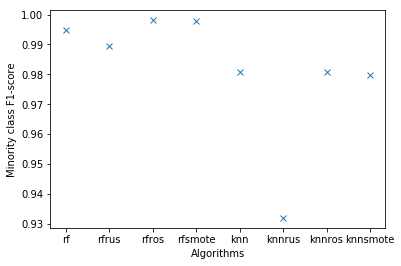

In [26]:
%matplotlib inline 
import matplotlib.pyplot as pl

# Plot histogram
x_data = ["rf", "rfrus", "rfros", "rfsmote", "knn", "knnrus", "knnros", "knnsmote"]
y_data = [f1_rf[1], f1_rfrus[1], f1_rfros[1], f1_rfsmote[1], best_f1_knn[1], best_f1_knn_rus[1], best_f1_knn_ros[1], best_f1_knn_smote[1]]
pl.xlabel("Algorithms")
pl.ylabel("Minority class F1-score")
pl.plot(x_data, y_data, 'x')

# GridSearch for RandomForest Classifier (an experiment)

Here is an attempt to use the GridSearch to find the best estimator (with best parameters) for RandomForest Classifier.
The unsampled data is the input to program.
Grid search is done with following random forest parameters.
parameters = {'class_weight':['balanced'],
              'criterion':['gini'],
              'max_depth': [10,20,30,40],
              'n_estimators': [50],
              'max_features': ['auto'],
              'n_jobs': [-1],
              'bootstrap': [True, False]}
Prepared own scoring function f1_high so as to target the minority class.

Here is the result with GridSearch.
F1 (None) = [0.99995244 0.99755927]

confusion_matrix = [[147165 , 2]
 [12 , 2861]]

The best RF params are selected as following.
gscv best params {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'n_estimators': 50, 'n_jobs': -1}

In [27]:
%%time

print(time.asctime())

## Grid Search to find the best parameters for RF

parameters = {'class_weight':['balanced'],
              'criterion':['gini'],
              'max_depth': [10,20,30,40],
              'n_estimators': [50],
              'max_features': ['auto'],
              'n_jobs': [-1],
              'bootstrap': [True, False]}
f1_high = metrics.make_scorer(metrics.f1_score, pos_label = 1, average = "binary")

gscv = GridSearchCV(RandomForestClassifier(), parameters, cv = 5, verbose=2, scoring = f1_high)
gscv.fit(X_train, y_train)

pickle.dump(file=open("gscv_model" + ".pkl", "wb"), obj=gscv)
print("\n GSCV object dumped to pickle")

print("\n gscv best score", gscv.best_score_)
print("\n gscv best params", gscv.best_params_ )
print("\n gscv best index", gscv.best_index_)
print("\n gscv best estimator", gscv.best_estimator_)

best_estimator = gscv.best_estimator_
predictions = []
predictions.append(best_estimator.predict(X_test))
testresult = np.array(predictions).sum(axis=0)
testresult = [0 if item == 0 else 1 for item in testresult]
testresult = pd.DataFrame(testresult)
testresult = testresult.iloc[:,0]
print("f1_score for both classes = {}".format(metrics.f1_score(y_true=y_test, y_pred=testresult, average=None)))
print("the confusion matrix is", metrics.confusion_matrix(y_true=y_test, y_pred=testresult))

avg_vals = ["micro", "macro", "weighted", None]

with open ("gscv_results.txt", "a") as cv:
    
    cv.write ("\n------------------best score----------------------------\n")
    cv.write (str (gscv.best_score_) + "\n")
    cv.write ("\n------------------best params---------------------------\n")
    cv.write (str (gscv.best_params_) + "\n")
    cv.write ("\n------------------best index of cv results--------------\n")
    cv.write (str (gscv.best_index_ ) + "\n")
    cv.write ("\n------------------best estimator------------------------\n")
    cv.write (str (gscv.best_estimator_) + "\n")
    
    cv.write ("------------------Scores----------------------------------\n")
    for avg_val in avg_vals:
        str_val = ("\n\nPrecision (" 
                   + str(avg_val) 
                   + ") = " 
                   + str(metrics.precision_score(y_true=y_test, y_pred=testresult, average=avg_val)))

        print (str_val)
        cv.write (str_val)
        
        str_val = ("\n\nRecall (" 
                   + str(avg_val) 
                   + ") = " 
                   + str(metrics.recall_score(y_true=y_test, y_pred=testresult, average=avg_val)))

        print (str_val)
        cv.write (str_val)
        
        str_val = ("\n\nF1 (" 
                   + str(avg_val) 
                   + ") = " 
                   + str(metrics.f1_score(y_true=y_test, y_pred=testresult, average=avg_val)))

        print (str_val)
        cv.write (str_val)
        
    str_val = ("\n\nconfusion_matrix"
                   + " = " 
                   + str(metrics.confusion_matrix(y_true=y_test, y_pred=testresult)))
    print (str_val)
    cv.write (str_val)
    
    cv.close()

Wed Nov 21 21:04:26 2018
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1, total=  45.6s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.9s remaining:    0.0s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1, total=  45.8s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1, total=  46.6s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1, total=  45.4s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=10, max_features=auto, n_estimators=50, n_jobs=-1, total=  47.3s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=20, max_features=auto, 

[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=30, max_features=auto, n_estimators=50, n_jobs=-1, total= 1.3min
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=30, max_features=auto, n_estimators=50, n_jobs=-1 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=30, max_features=auto, n_estimators=50, n_jobs=-1, total= 1.3min
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=40, max_features=auto, n_estimators=50, n_jobs=-1 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=40, max_features=auto, n_estimators=50, n_jobs=-1, total= 1.3min
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=40, max_features=auto, n_estimators=50, n_jobs=-1 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=40, max_features=auto, n_estimators=50, n_jobs=-1, total= 1.3min
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=40, max_feature

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 44.5min finished



 GSCV object dumped to pickle

 gscv best score 0.9962900490496053

 gscv best params {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 50, 'n_jobs': -1}

 gscv best index 6

 gscv best estimator RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=30, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
f1_score for both classes = [0.99994904 0.99738448]
the confusion matrix is [[147165      2]
 [    13   2860]]


Precision (micro) = 0.9999000266595575


Recall (micro) = 0.9999000266595575


F1 (micro) = 0.9999000266595575


Precision (macro) = 0.9996064297808919


Recall (macro) = 0.9977307615594

# The best estimator for submission

The plots made earlier (with all the test results), makes it quite evident that we have got the best results with random forest classifier over the random and SMOTE oversampled data. Let us redo the training and validation once again(we selected the random oversampled data), and save the model for later testing. We used random_state parameter as 10 for consistency in behaviour when re-executing the code.

The model is saved in a pickle file "rf_model.pkl" which an can be used in testing phase. Refer testing instructions in the final cell.

In [33]:
%%time

print(time.asctime())

## Fit SMOTE train data to RF estimator
X = pd.read_pickle("rostraininginputpickle")
y = pd.read_pickle("rostrainingoutputpickle")
rf = RandomForestClassifier(n_estimators=50,class_weight = "balanced", random_state = 10)
rf.fit(X, y.iloc[:,0])
predictions = rf.predict(X_test)
f1_rfros = metrics.f1_score(y_true=y_test, y_pred=predictions, average=None)
print("f1_score for both classes = {}".format(f1_rfros))
print("the confusion matrix is", metrics.confusion_matrix(y_true=y_test, y_pred=predictions))
print(rf)

pickle.dump(file=open("rf_model" + ".pkl", "wb"), obj=rf)
print("\n RFECV object dumped to pickle")

print("\n the shape of final training data", X.shape)
with open('final_trained_features.pkl', 'wb') as f:
    pickle.dump(X.columns, f)

Thu Nov 22 09:39:57 2018
f1_score for both classes = [0.99995923 0.99790868]
the confusion matrix is [[147165      2]
 [    10   2863]]
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

 RFECV object dumped to pickle

 the shape of final training data (782929, 63)
CPU times: user 4min 48s, sys: 6.11 s, total: 4min 54s
Wall time: 2min 27s


Cleaning
This code is now commented.

In [29]:
##del X_train
##del y_train
##del X_test
##del y_test
##del train_df
##del anomalies_df
##del X_ros
##del y_ros
##del X_rus
##del y_rus
##del X_smote
##del y_smote
##del X_tlink
##del y_tlink

# Testing instructions

Perform the following steps:

Note: when you are running this program the path of source files are to be appropriately set(cell #3).

1. Read the test data into a python dataframe.

2. Extract the "isAnomaly" feature from the test data (if not already seperated), and replace "True" and "False" with 1 
   and 0 respectively (reference code in Cell #5 and Cell #6).

3. Execute the same procedure that we have followed and generate the same dataframe from the originally given training 
   data (have to perform feature filtering (finally only 63 features exist, then do MinMaxScaling, then do SMOTE 
   oversampling and generate the dataframe)). Reference code for feature filtering is in Cells #7, #8 and #9. The 
   reference code for MinMax scaling in cell #10. The refence code for SMOTE oversampling is in cell #13.
   
4. Keep the same feature set in test data(i.e., only 63 features should be there, remove the rest from test data too). 
   The finally trained feature set is also captured in "final_trained_features.pkl" for your reference.

4. Load the best estimator in rf_model.pkl(Refer cell #28). Or else you can build the model as we have built here in Cell 
   #28.

5. Predict the result using test data on this model.

Additional note: If you are running this whole program (the attached .ipynb program), it may be better to modify the 
KNN n_neighbors iterator to 1 (now it runs for 10 iterations) as otherwise it would take much time to finish the 
execution(also best results with KNN is always there with n_ neighbors = 1 and 2)